FileNotFoundError: [Errno 2] No such file or directory: 'feh'

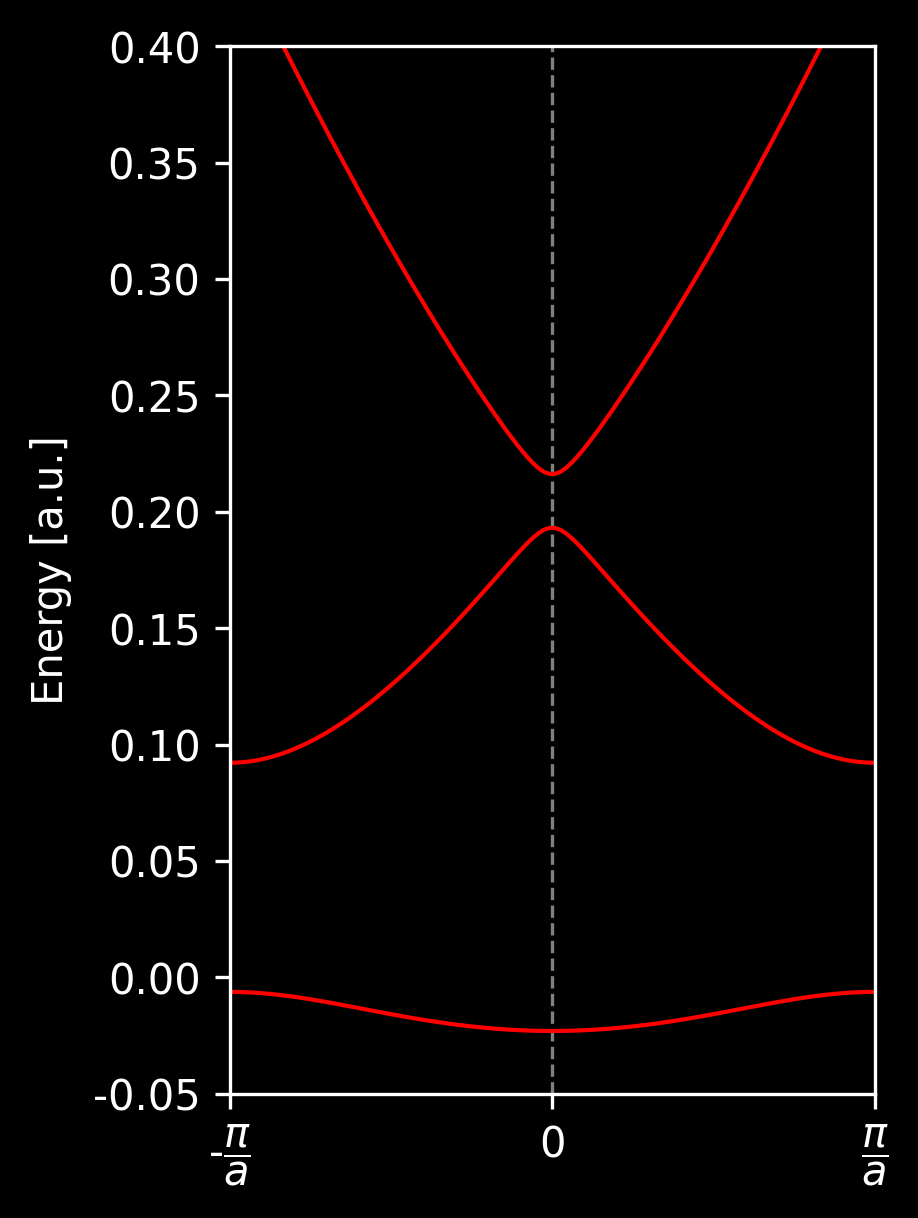

In [4]:
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh

def epsilon_nk_cosx_pot(k=0, a=10, v0=1.0, ngx=10, nbnds=5, Ngmax=1):
    '''
    Return the eigen-energies of the cosine potential

    V(x) = \sum_{n=1}^N 2*V_0 cos( n*2pi/a x)

    Reference:
    http://staff.ustc.edu.cn/~zqj/assets/courseware/ssp/pdf/chap_5.1_nearly_free_electron.pdf
    '''
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    b   = 2*np.pi / a
    Gx  = Gx * b
    k  *= b

    lambda_kG = 0.5 * (k + Gx)**2
    Hij = np.diag(lambda_kG)

    nn = range(ngx)
    for ii in range(1,Ngmax+1):
        Hij[nn[:-ii], nn[ii:]] = v0
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = v0

        Hij[nn[ii:], nn[:-ii]] = v0
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = v0
    
    E, phi = np.linalg.eigh(Hij) 

    return E[:nbnds], phi[:,:nbnds].T

################################################################################

if __name__ == "__main__":
    a     = 10                     # Periodicity in Bohr
    b     = 2*np.pi / a
    nkpts = 120
    nbnds = 5
    k0    = np.linspace(-0.5, 0.5, nkpts, endpoint=True)

    # free electron dispersion
    ################################################################################

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    mpl.rcParams['axes.unicode_minus'] = False
    # plt.style.use('dark_background')
    
    fig = plt.figure(
      figsize=(3.0, 4.0),
      dpi=300,
    )
    ax = plt.subplot()
    ################################################################################

    v0 = 0.05
    Enk = np.array([
        epsilon_nk_cosx_pot(k, a, v0, nbnds=nbnds, Ngmax=1)[0]
        for k in k0
    ])

    # ax.axhline(y=0, color='gray', ls='--', lw=0.8)
    ax.axvline(x=0, color='gray', ls='--', lw=0.8)

    # ax.axhline(y=v0, color='green', ls='--', lw=0.8)

    for ii in range(Enk.shape[1]):
        ax.plot(k0, Enk[:,ii], color='r', lw=1.0)
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-v0, 0.4)

    ax.set_xticks([-0.5, 0, 0.5])
    ax.set_xticklabels([r'-$\dfrac{\pi}{a}$', r'$0$', r'$\dfrac{\pi}{a}$'])

    ax.set_ylabel('Energy [a.u.]', labelpad=5)
    
    plt.tight_layout(pad=0.5)
    # plt.show()

    plt.savefig('mpl_cosx_ngmx1.png', dpi=400)

    from subprocess import call
    call('feh -xdF mpl_cosx_ngmx1.png'.split())

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_30791/100569436.py:75: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))


FileNotFoundError: [Errno 2] No such file or directory: 'feh'

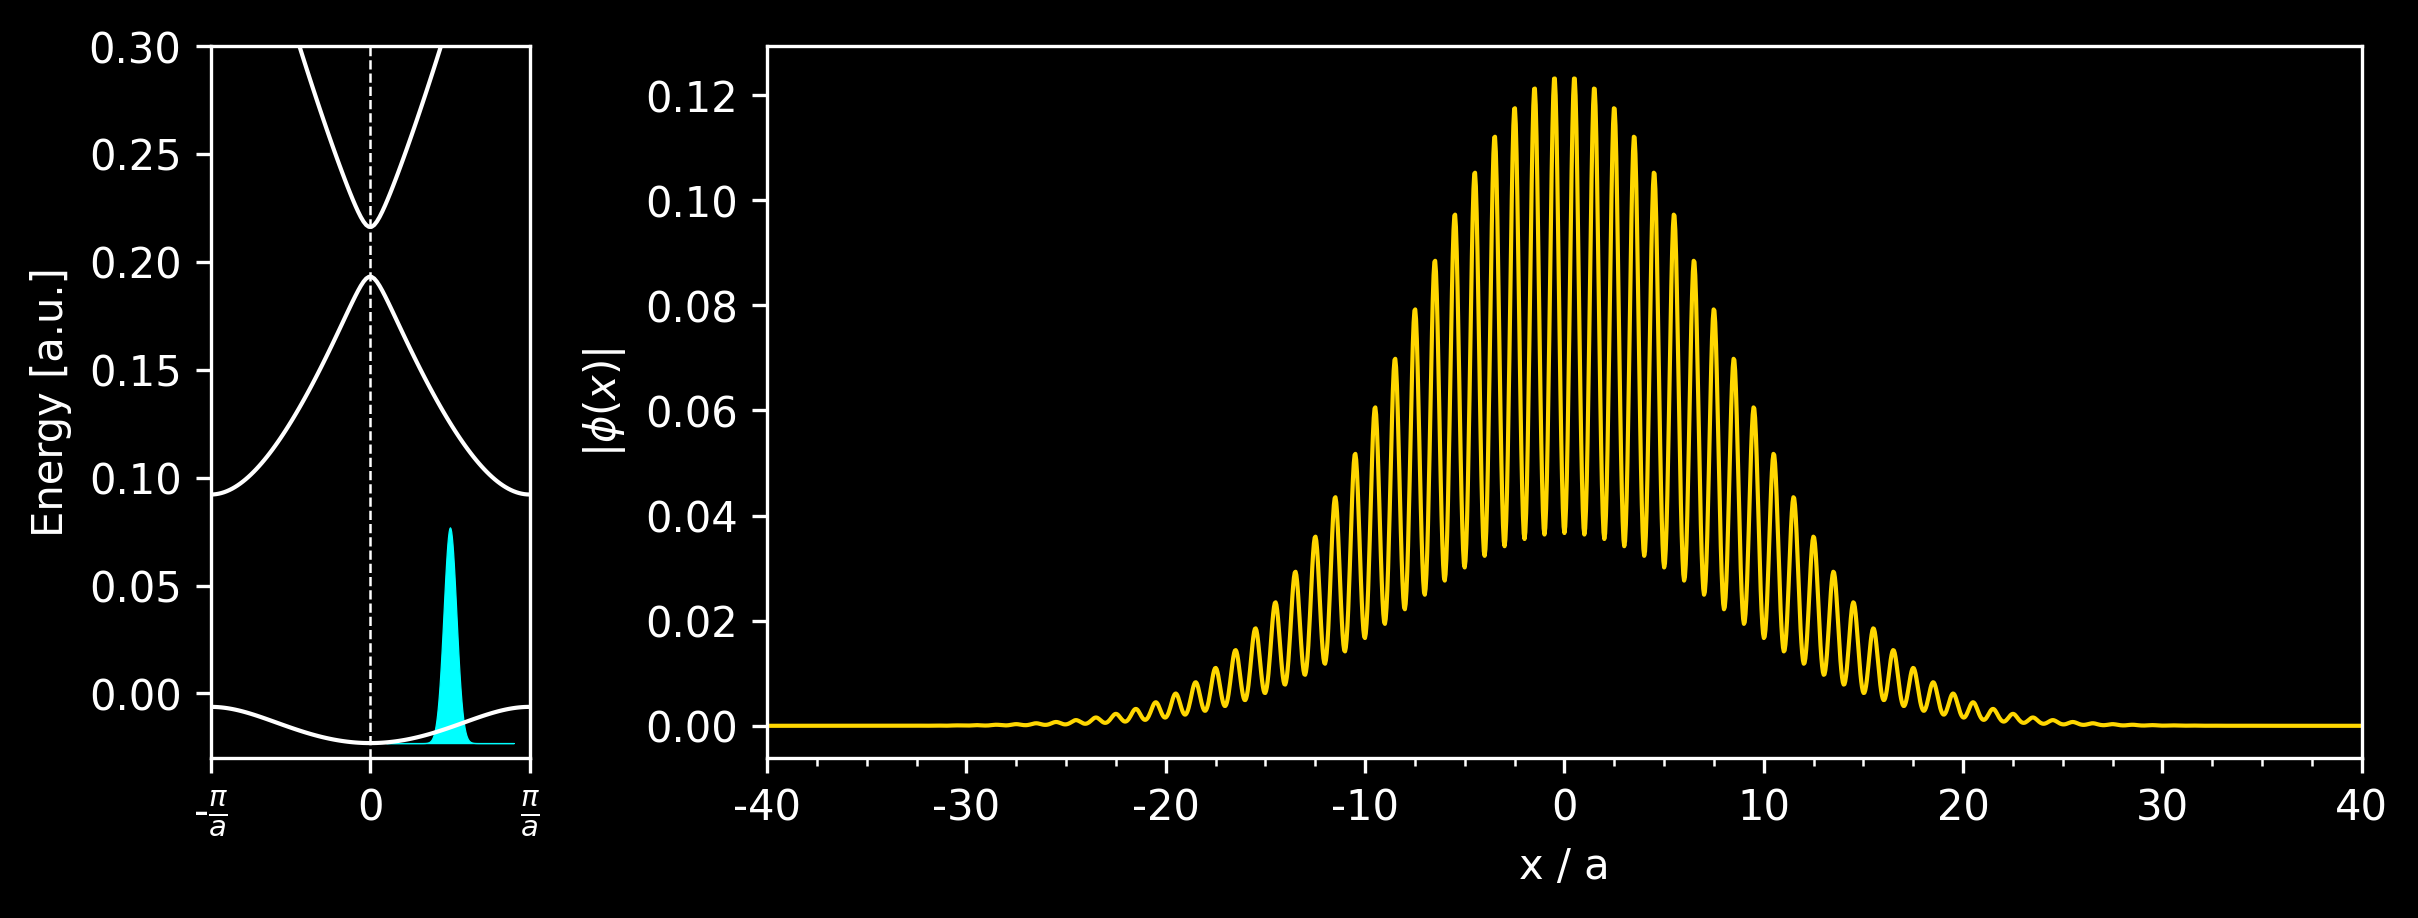

In [5]:
#!/usr/bin/env python

import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh, splu


def epsilon_nk_cosx_pot(k=0, a=10, v0=1.0, ngx=10, nbnds=5, Ngmax=1):
    '''
    Return the eigen-energies of the cosine potential

    V(x) = \sum_{n=1}^N 2*V_0 cos( n*2pi/a x)

    Reference:
    http://staff.ustc.edu.cn/~zqj/assets/courseware/ssp/pdf/chap_5.1_nearly_free_electron.pdf
    '''
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    b  = np.pi * 2 / a
    Gx = Gx * b
    k  = k * b

    lambda_kG = 0.5 * (k + Gx)**2
    Hij = np.diag(lambda_kG)

    nn = range(ngx)
    for ii in range(1,Ngmax+1):
        Hij[nn[:-ii], nn[ii:]] = v0
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = v0

        Hij[nn[ii:], nn[:-ii]] = v0
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = v0
    
    E, phi = np.linalg.eigh(Hij) 

    return E[:nbnds], phi[:,:nbnds].T

def get_bloch_wavepacket_gaussian_envelop(k0, sigma_k, nk=20, Nsigma=10):
    '''
    '''
    assert -0.5 <= k0 <= 0.5

    delta_k = Nsigma * sigma_k
    ktmp    = np.linspace(0, delta_k, nk, endpoint=True)
    k1      = np.r_[-ktmp[::-1][:-1], ktmp]

    k2 = k1 + k0
    k2[k2 >= 0.5] -= 1.0
    k2[k2 <=-0.5] += 1.0
    fk = np.sqrt(1 / np.sqrt(np.pi) / sigma_k) * np.exp(-k1**2/(2*sigma_k**2))

    return k2, fk

def construct_blochwp_cosx_pot(x, kwp, fk, n0=0, 
        v0=0.05, a=1, nbnds=5, ngx=20):
    '''
    '''
    Nx  = x.size
    b   = 2*np.pi / a

    Cng = []
    for k in kwp:
        E, C = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
        Cng.append(C)
    Cng = np.array(Cng)

    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    bloch_wp = np.zeros(Nx, dtype=complex)
    for ik, k in enumerate(kwp):
        for ig, g in enumerate(Gx):
            bloch_wp[:] += np.exp(1j*(k+g)*x*b) * fk[ik] * Cng[ik,n0,ig]
    bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))

    return bloch_wp


################################################################################

if __name__ == "__main__":
    a  = 10         # Periodicity in Bohr
    b  = 2*np.pi / a
    v0 = 0.05

    # bloch wavepacket in reciprocal space
    n0       = 0
    k0       = 0.25
    sigma_k  = 0.02
    nbnds    = 5
    ngx      = 20
    kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k,
            nk=100, Nsigma=10)
    
    # band structure
    k_1d_bz = np.linspace(-0.5, 0.5, 120)
    Enk = np.array([
        epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)[0]
        for k in k_1d_bz
    ])

    # bloch wavepacket in real space
    Nc       = 160        # No. of Cells
    L        = Nc * a
    Nx       = 3999
    x        = np.linspace(-L/2, L/2, Nx)
    dx       = x[1] - x[0]
    bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)


    ################################################################################
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.ticker import AutoMinorLocator

    mpl.rcParams['axes.unicode_minus'] = False
    plt.style.use('dark_background')
    ############################################################

    fig = plt.figure(
        figsize=(8.0, 3.0),
        dpi=300,
        # constrained_layout=True,
    )
    axes = fig.subplot_mosaic(
        [[0, 1]],
		empty_sentinel=None,
		# set the height ratios between the rows
		height_ratios=[1],
		# set the width ratios between the columns
		width_ratios=[1, 5],
	)
    axes = [axes[ii] for ii in range(2)]

    ############################################################
    ax = axes[0]
    ax.axvline(x=0, lw=0.6, ls='--', color='w')

    emin = Enk.min()

    # ax.plot(kwp, fk * np.sqrt( np.sqrt(np.pi) * sigma_k) * 0.1 + emin, lw=0.5,
    #         color='r')
    ax.fill_between(
        kwp, emin, fk * np.sqrt( np.sqrt(np.pi) * sigma_k) * 0.1 + emin,
        lw=0.3, color='cyan',
    )

    for ii in range(nbnds):
        ax.plot(k_1d_bz, Enk[:,ii], color='w', lw=1.0)

    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
    ax.set_ylim(-0.03, 0.30)

    ax.set_ylabel('Energy [a.u.]')

    ############################################################
    ax = axes[1]

    ax.plot(x / a, np.abs(bloch_wp), color='gold', lw=1.0)

    ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))

    ax.set_xlim(-40, 40)

    ax.set_ylabel(r'|$\phi(x)|$')
    ax.set_xlabel(r'x / a')
    ############################################################
    plt.tight_layout(pad=0.5, w_pad=1.0)
    plt.savefig('semiclassical_schematics_1d_cosx_pot_dark.png')
    # plt.show()

    from subprocess import call
    call('feh -xdF semiclassical_schematics_1d_cosx_pot_dark.png'.split())
    

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_69028/3369653680.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))


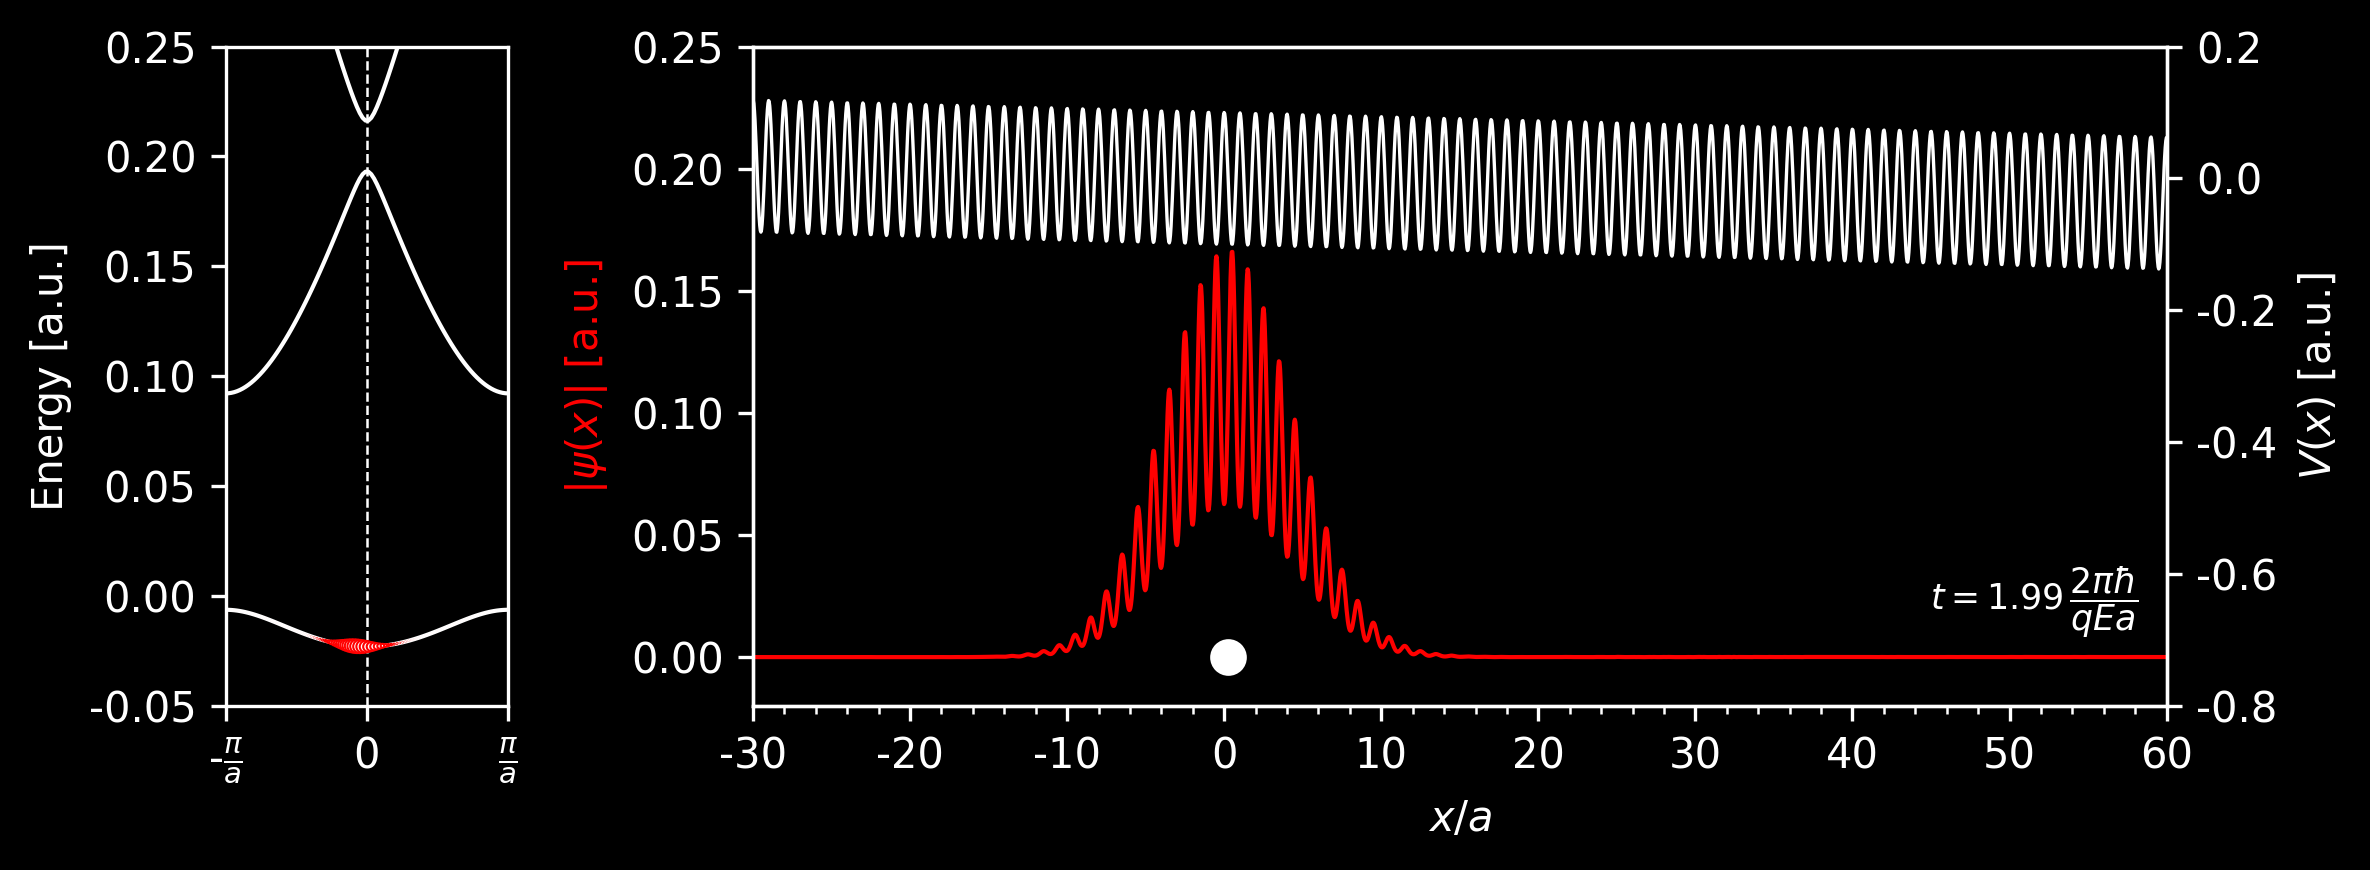

In [1]:
#!/usr/bin/env python

import os
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh, splu

def CrankNicolson(psi0, V, x, dt, N=100, print_norm=False):
    '''
    Crank-Nicolson method for the 1D Schrodinger equation.
    '''
    # No. of spatial grid points
    J  = x.size - 1
    dx = x[1] - x[0]

    # the external potential
    V = spa.diags(V)
    # the kinetic operator
    O = np.ones(J+1)
    T = (-1 / 2 / dx**2) * spa.spdiags([O, -2*O, O], [-1, 0, 1], J+1, J+1)

    # the two unitary matrices
    U2 = spa.eye(J+1) + (1j * 0.5 * dt) * (T + V)
    U1 = spa.eye(J+1) - (1j * 0.5 * dt) * (T + V)
    # splu requires CSC matrix format for efficient decomposition
    U2 = U2.tocsc()
    LU = splu(U2)

    # Store all the wavefunctions
    PSI_t = np.zeros((J+1, N), dtype=complex)
    # the initial wavefunction
    PSI_t[:, 0] = psi0

    for n in range(N-1):
        b            = U1.dot(PSI_t[:,n])
        PSI_t[:,n+1] = LU.solve(b)
        if print_norm:
            print(n, np.trapz(np.abs(PSI_t[:,n+1])**2, x))

    return PSI_t

def epsilon_nk_cosx_pot(k=0, a=10, v0=1.0, ngx=10, nbnds=5, Ngmax=1):
    '''
    Return the eigen-energies of the cosine potential

    V(x) = \sum_{n=1}^N 2*V_0 cos( n*2pi/a x)

    Reference:
    http://staff.ustc.edu.cn/~zqj/assets/courseware/ssp/pdf/chap_5.1_nearly_free_electron.pdf
    '''
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    b   = 2*np.pi / a
    Gx  = Gx * b
    k  *= b

    lambda_kG = 0.5 * (k + Gx)**2
    Hij = np.diag(lambda_kG)

    nn = range(ngx)
    for ii in range(1,Ngmax+1):
        Hij[nn[:-ii], nn[ii:]] = v0
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = v0

        Hij[nn[ii:], nn[:-ii]] = v0
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = v0
    
    E, phi = np.linalg.eigh(Hij) 

    return E[:nbnds], phi[:,:nbnds].T

def get_bloch_wavepacket_gaussian_envelop(k0, sigma_k, nk=20, Nsigma=5):
    '''
    '''
    assert -0.5 <= k0 <= 0.5

    delta_k = Nsigma * sigma_k
    ktmp    = np.linspace(0, delta_k, nk, endpoint=True)
    k1      = np.r_[-ktmp[::-1][:-1], ktmp]

    k2 = k1 + k0
    k2[k2 >= 0.5] -= 1.0
    k2[k2 <=-0.5] += 1.0
    fk = np.sqrt(1 / np.sqrt(np.pi) / sigma_k) * np.exp(-k1**2/(2*sigma_k**2))

    return k2, fk

def construct_blochwp_cosx_pot(x, kwp, fk, n0=0, 
        v0=0.05, a=1, nbnds=5, ngx=20):
    '''
    '''
    Nx  = x.size
    b   = 2*np.pi / a

    Cng = []
    for k in kwp:
        E, C = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
        Cng.append(C)
    Cng = np.array(Cng)

    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    bloch_wp = np.zeros(Nx, dtype=complex)
    for ik, k in enumerate(kwp):
        for ig, g in enumerate(Gx):
            bloch_wp[:] += np.exp(1j*(k+g)*x*b) * fk[ik] * Cng[ik,n0,ig]
    bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))

    return bloch_wp
################################################################################

if __name__ == "__main__":
    a  = 10         # Periodicity in Bohr
    b  = 2*np.pi / a
    v0 = 0.05

    # bloch wavepacket in reciprocal space
    n0       = 0
    k0       = 0
    sigma_k  = 0.04
    nbnds    = 5
    ngx      = 20
    kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k,
            nk=100, Nsigma=10)
    
    # bloch wavepacket in real space
    Nc       = 150        # No. of Cells
    L        = Nc * a
    Nx       = 3999
    x        = np.linspace(-0.4*L, 0.6*L, Nx)
    dx       = x[1] - x[0]
    bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)

    # band structure and bloch states
    k_1d_bz = np.linspace(-0.5, 0.5, 100)
    # Cng     = []
    Enk     = []
    phi_nk  = []

    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx
    for k in k_1d_bz:
        e, c = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
        Enk.append(e)
        # Cng.append(c)
        cg = c[n0]
        phi_nk.append(
            np.sum(cg[:,None]*np.exp(1j*b*(Gx+k)[:,None] * x[None,:]), axis=0)
        )
    Enk = np.asarray(Enk)
    phi_nk = np.asarray(phi_nk)
    # print(phi_nk.shape)

    # Time evolution of the Bloch wavepacket
    qE     = 2*np.pi / 1E5
    Vx     = 2* v0 *np.cos(b*x) - qE*x
    dt     = 10
    Tbloch = 2 * np.pi / (qE * a)
    NSW    = 2 * int(Tbloch / dt)
    PSI0   = CrankNicolson(bloch_wp, Vx, x, dt, NSW, False)


    # average position of the wavepacket
    X0  = np.sum((np.abs(PSI0)**2) * x[:, None], axis=0) / np.sum((np.abs(PSI0)**2), axis=0)
    X0 /= a
    np.savetxt('x0_blochwp.dat', np.c_[np.arange(NSW)*dt/Tbloch, X0])

    if os.path.isfile('kproj.npy'):
        kwht = np.load('kproj.npy')
        # kc   = np.sum(np.abs(kwht) * k_1d_bz, axis=1) / np.sum(np.abs(kwht), axis=1)
        kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]
    else:
        # projection of the wavepacket onto the Bloch state
        kwht = []
        for ii in range(NSW):
            kwht.append(
                np.sum(
                    phi_nk.conj() * PSI0[:,ii][None,:],
                    axis=1
                )
            )
        kwht = np.array(np.abs(kwht))
        kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]
        np.save('kproj.npy', kwht)

    np.savetxt('k0_blochwp.dat', np.c_[np.arange(NSW)*dt/Tbloch, kc])

    Nsave  = NSW // 16
    np.savetxt('td_blochwp_snapshots.dat', np.c_[x/a, np.abs(PSI0[:,::Nsave])][::2,:],
            fmt='%10.5f')
    ################################################################################
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.ticker import AutoMinorLocator

    mpl.rcParams['axes.unicode_minus'] = False
    plt.style.use('dark_background')
    ############################################################

    fig = plt.figure(
        figsize=(8.0, 3.0),
        dpi=300,
        # constrained_layout=True,
    )
    axes = fig.subplot_mosaic(
        [[0, 1]],
		empty_sentinel=None,
		# set the height ratios between the rows
		height_ratios=[1],
		# set the width ratios between the columns
		width_ratios=[1, 5],
	)
    axes = [axes[ii] for ii in range(2)]
    ############################################################
    ax = axes[0]
    ax.axvline(x=0, lw=0.6, ls='--', color='w')

    emin = Enk.min()

    # ax.fill_between(
    #     kwp, emin, fk * np.sqrt( np.sqrt(np.pi) * sigma_k) * 0.1 + emin,
    #     lw=0.3, color='red',
    # )

    for ii in range(nbnds):
        ax.plot(k_1d_bz, Enk[:,ii], color='w', lw=1.0, zorder=1)

    scat = ax.scatter(
        k_1d_bz, Enk[:,n0], s=np.abs(kwht[0]) / 3,
        lw=0.5, color='r', facecolor='w', zorder=2
    )

    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
    ax.set_ylim(-0.05, 0.25)

    ax.set_ylabel('Energy [a.u.]')
    ############################################################
    ax = axes[1]
    axt = ax.twinx()

    l0, = ax.plot(x / a, np.abs(PSI0[:,0]), lw=1.0,
            color='red')
    l1, = ax.plot([X0[0]], [0], ls='none',
            marker='o', ms=8, mew=0.8, mfc='w', color='w')

    axt.plot(x / a, Vx, lw=0.8,
            label=r'$V(x)$', color='w')

    # ax.legend(loc='upper right')
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
    
    time_stamp = ax.text(
        0.98, 0.10,
        # r"$k_0={}\,$a.u.".format(k0) + "\n" + r'$t={:6.2f}\,$a.u.'.format(0),
        r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(0),
        ha='right', va='bottom',
        family='monospace',
        fontsize='small',
        transform=ax.transAxes,
        # bbox=dict(boxstyle='round', facecolor='black', alpha=0.5),
    )

    ax.set_ylim(-0.02, 0.25)
    axt.set_ylim(-0.80, 0.20)
    # ax.set_xlim(x.min() / a, x.max()/a)
    ax.set_xlim(-30, 60)

    ax.set_xlabel(r'$x / a$', labelpad=5)
    ax.set_ylabel(r'$|\psi(x)|$ [a.u.]', labelpad=5, color='red')
    axt.set_ylabel(r'$V(x)$ [a.u.]', labelpad=5, color='w')
    ############################################################

    plt.tight_layout()
    ############################################################

    def wfc_propagation(iframe):
        l0.set_ydata(np.abs(PSI0[:,iframe*10]))
        l1.set_xdata([X0[iframe*10]])
        # l1.set_ydata([0])
        # l0.set_ydata(PSI0[:,iframe].real)
        # l1.set_ydata(np.abs(PSI1[:,iframe]))

        scat.set_sizes(np.abs(kwht[iframe*10]) / 3)

        time_stamp.set_text(
            r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(iframe * 10 * dt / Tbloch),
            # r"$k_0={}\,$a.u.".format(k0) + "\n" + r'$t={:6.2f}\,$a.u.'.format(dt * iframe * 10),
        )

        return l0, l1, scat, time_stamp,

    ani = animation.FuncAnimation(
        fig,
        wfc_propagation,
        interval=40,
        blit=True,
        repeat=True,
        frames=NSW//10,
    )
    ############################################################

    # use "imagemagick" writer to make loop gif
    # ani.save('gaus_wfc_k{}.gif'.format(k0), writer='imagemagick')

    # ani.save('1d_bloch_oscillation.gif')
    ani.save('bloch_oscillation_tise.mp4', writer='ffmpeg', dpi=300)

    plt.show()